## Test et anlyse du modèle DIST_REL_C_01

De la même façon que nous avons procédé pour le modèle DIST_REL_C_RNN_01, nous allons créer des représentations graphiques des performances, puis nous allons comparer les deux modèles.

#### Chemins des fichiers

In [126]:

model_loc = "../models/DIST_REL_C_01/11.0/DIST_REL_C_01_basic.tflearn"

figures_loc = "../figures/11.1-"

test_set_prepared_input_loc = "../data/DIST_REL_C_RNN/test_set_prepared_input.h5"
test_set_labels_loc = "../data/DIST_REL_C_RNN/test_set_labels.h5"

train_riken_reduced_loc = "../data/train_set_riken_v2_reduced.h5"
test_riken_reduced_loc = "../data/test_set_riken_v2_reduced.h5"

"""
train_riken_reduced_loc = "../data/minimal_set_riken_v2_reduced.h5"
test_riken_reduced_loc = "../data/minimal_set_riken_v2_reduced.h5"

test_set_prepared_input_loc = "../data/DIST_REL_C_RNN/minimal_prepared_input.h5"
test_set_labels_loc = "../data/DIST_REL_C_RNN/minimal_labels.h5"
"""

### Création du RN

#### Fonction de coût (RMSE)

In [127]:
def rmse(pred, targets):
    with tf.name_scope("rmse_loss"):
        return tf.sqrt(tf.reduce_mean(tf.squared_difference(pred, targets)), name="rmse")

#### Fonction d'évaluation des performances (opposé du RMSE)

In [128]:
def rmse_valid(pred, targets, inputs):
    with tf.name_scope("rmse_validation"):
        return -rmse(pred, targets)

#### Fonction de création du RN


In [129]:
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
from tflearn.optimizers import Adam
from tflearn.data_preprocessing import DataPreprocessing
import math


def creer_RN(epsilon=1e-8, learning_rate=0.001, dropout_val=0.99, stddev_init=0.001,
             hidden_act='relu', outlayer_act='prelu', weight_decay=0.001, width=870, depth=3,
             validation_fun=rmse_valid, cost_fun=rmse):

    # On créé l'initialisateur de tenseur avec une loi normale tronquée. sigma = stddev_init, et les 
    # valeurs à plus de 2sigma sont re-tirées
    winit = tfl.initializations.truncated_normal(stddev=stddev_init, dtype=tf.float32, seed=None)
    
    # On créé l'input du RN
    network = input_data(shape=[None, 870], name='input')
    
    # On créé les couches cachées
    for i in range(depth):
        network = fully_connected(network, width, activation=hidden_act, name='fc'+str(i), weights_init=winit,
                                  weight_decay=weight_decay)
        # On détruit des neurones aléatoirement avec une la probabilité donnée en entrée
        network = dropout(network, dropout_val)
    
    # On ajoute la couche de sortie du réseau
    # Fonction d'activation prelu
    # Initilisée avec la loi normale tronquée
    network = fully_connected(network, 1, activation=outlayer_act, name='outlayer', weights_init=winit)
    
    adam = Adam(learning_rate=learning_rate, epsilon=epsilon)
    
    # Couche d'évaluation du modèle. Utilisation d'une descente stochastique Adam
    # Learning rate = 0.05
    # Loss = fonction définie rmse
    network = regression(network, optimizer=adam,
    loss=cost_fun, metric=validation_fun, name='target')
            
    return network

## Calcul des prédictions

#### Calcul du RMSE sur des vecteurs

In [130]:
import numpy as np

def rmse_test(targets, predictions):
    return np.sqrt(np.square(np.diff([targets, predictions], axis=0)))[0]

#### Calcul de l'erreur sur chaque exemple du jeu de test

In [131]:
import h5py
from tflearn.data_utils import pad_sequences
import tensorflow as tf
import tflearn as tfl

def calculer_pred(model_loc, test_set_prepared_input_loc, test_set_labels_loc):
    """ Renvoie l'erreur et la prédiction pour chaque exemple du jeu de test """
    
    tf.reset_default_graph()
    
    # Importation du modèle
    network = creer_RN(learning_rate=0.01, dropout_val=0.98, epsilon=0.001, hidden_act="elu", outlayer_act="linear", width=870, depth=3)
    model = tfl.DNN(network)
    model.load(model_loc, weights_only=True)
    
    # Chargement des données
    inputs_h5 = h5py.File(test_set_prepared_input_loc, 'r')
    targets_h5 = h5py.File(test_set_labels_loc, 'r')
    
    inputs = np.array(inputs_h5["inputs"])
    inputs = pad_sequences(inputs, dtype="float32", maxlen=870)
    inputs = inputs.reshape(-1, 870)
    
    targets = np.array(targets_h5["targets"])
    targets = targets.reshape(-1, 1)
    
    predictions = model.predict(inputs)
    
    return rmse_test(targets, predictions).reshape(1, -1)[0], predictions
    
    

In [132]:
rmses, predictions = calculer_pred(model_loc, test_set_prepared_input_loc, test_set_labels_loc)


INFO:tensorflow:Restoring parameters from /home/etudiant/Documents/Cours/TER/Notebooks/models/DIST_REL_C_01/11.0/DIST_REL_C_01_basic.tflearn


#### Affichage des statistiques sur les erreurs

In [141]:
def print_stats_rmse(rmses):
    print("Erreur moyenne : "+str(np.mean(rmses)))
    print("Erreur médiane : "+str(np.median(rmses)))
    print("Écart-type : "+str(np.std(rmses)))
    print("Erreur min : "+str(min(rmses)))
    print("Erreur max : "+str(max(rmses)))
    
print_stats_rmse(rmses)

Erreur moyenne : 86.3501
Erreur médiane : 83.52832
Écart-type : 57.627506
Erreur min : 0.030273438
Erreur max : 1031.1377


##### Sortie

```
Erreur moyenne : 12.826389
Erreur médiane : 6.0214844
Écart-type : 20.240458
Erreur min : 0.0
Erreur max : 285.42126
```

### Analyse

On voit ici que le modèle produit en général de bons résultats. La moitié des erreurs est en dessous de 6 mÅ ce qui correspond à une grande précision des estimations.

Toutefois, on remarque que le modèle produit également de grandes erreurs sur certaines liaisons et que l'écart-type est élevé par rapport à l'ordre de grandeur de la médiane.

On a donc un modèle qui prédit très bien la moitié des données, et qui prédit mal l'autre moitié. Nous allons tenter de comprendre quelles sont les valeurs typiques qui sont bien ou mal prédites.

#### Récupération du vecteur cibles (distances)

In [133]:
def extract_targets(test_set_labels_loc):
    targets_h5 = h5py.File(test_set_labels_loc, 'r')
    targets = np.array(targets_h5["targets"])
    targets = targets.reshape(-1, 1)
    return targets

targets = extract_targets(test_set_labels_loc)


### Représentation graphique de la distribution des erreurs selon leur valeur

In [134]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['agg.path.chunksize'] = 10000


def plot_distrib_rmses_val(rmses, padding):
    """ Affiche la distribution des rmses selon un pas donné """
    
    # On calcule les bornes de notre index
    debut_index = np.floor(min(rmses))
    fin_index = max(rmses)+padding
    
    # On créé l'index des rmses
    index = np.arange(debut_index, fin_index, padding)
    
    # On créé le compteur de rmses
    rmse_occ = np.zeros_like(index)
        
    # Calcul des rmse
    for rmse in rmses:
        rmse_occ[int((rmse-debut_index)/padding)] += 1
                    
    plt.xlabel("Erreur absolue (par tranches de "+str(padding)+" mÅ)")
    plt.ylabel("Occurences sur le jeu de test")
    plt.title("Modèle DIST_REL_C_01\nDistribution des erreurs selon leur valeur")
    plt.plot(index, rmse_occ)
    plt.savefig(figures_loc+"DIST_REL_C_01_distrib_rmse_val.png", dpi=200)
    
    plt.show()



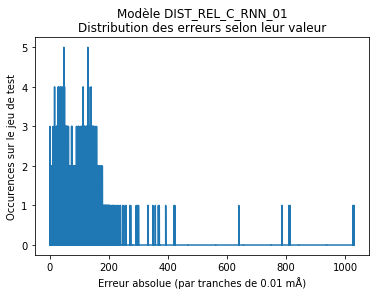

In [135]:
plot_distrib_rmses_val(rmses, 0.01)

![title](../figures/11.1-DIST_REL_C_01_distrib_rmse_val.png)


### Analyse

Ce graphe confirme 

#### Distribution des erreurs selon la distance à prédire

In [136]:
def plot_rmse_distrib_dist(rmses, targets):
    
    plt.title("Modèle DIST_REL_C_01\nDistribution des erreurs selon les distances cibles")
    plt.xlabel("Distance cible (mÅ)")
    plt.ylabel("Erreur absolue (mÅ)")
    plot = plt.plot(targets, rmses, ",")
    
    plt.annotate('', xy=(1380, 240), xytext=(1430, 240),
            arrowprops=dict(facecolor='red', shrink=0.05)
            )
    
    plt.text(1440, 228, "Longueur de liaison\ntypique")
    
    

    plt.annotate('triple', xy=(1200, 0), xytext=(1200, 30),
            arrowprops=dict(facecolor='red', shrink=0.05)
            )
    
    plt.annotate('double', xy=(1340, 0), xytext=(1280, 30),
            arrowprops=dict(facecolor='red', shrink=0.05),
            )
    
    plt.annotate('simple', xy=(1540, 0), xytext=(1522, 30),
            arrowprops=dict(facecolor='red', shrink=0.05),
            )
    
    plt.annotate('aromatique', xy=(1400, 0), xytext=(1337, 30),
            arrowprops=dict(facecolor='red', shrink=0.05),
            )
        
    plt.savefig(figures_loc+"DIST_REL_C_01_distrib_rmse_dist.png", dpi=200)
    
    plt.show()
    


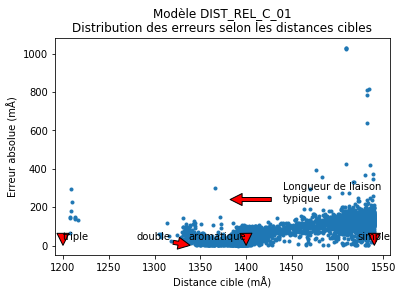

In [137]:
plot_rmse_distrib_dist(rmses, targets)

![title](../figures/11.1-DIST_REL_C_01_distrib_rmse_dist.png)


#### Visualisation des prédictions selon les distances attendues

In [142]:
def plot_sorted_targets_pred(targets, preds):
        
    plt.title("Modèle DIST_REL_C_01\n Prédictions en fonction des distances cibles")
    plt.xlabel("Distance cible (mÅ)")
    plt.ylabel("Distance prédite (mÅ)")
    
    plt.plot(targets, preds, ",")
    
    plt.annotate('', xy=(1380, 240), xytext=(1430, 240),
            arrowprops=dict(facecolor='red', shrink=0.05)
            )
    
    plt.text(1440, 228, "Longueur de liaison\ntypique")
    
    

    plt.annotate('triple', xy=(1200, 0), xytext=(1200, 300),
            arrowprops=dict(facecolor='red', shrink=0.05)
            )
    
    plt.annotate('double', xy=(1340, 0), xytext=(1280, 300),
            arrowprops=dict(facecolor='red', shrink=0.05),
            )
    
    plt.annotate('simple', xy=(1540, 0), xytext=(1522, 300),
            arrowprops=dict(facecolor='red', shrink=0.05),
            )
    
    plt.annotate('aromatique', xy=(1400, 0), xytext=(1337, 300),
            arrowprops=dict(facecolor='red', shrink=0.05),
            )
    
    axes = plt.gca()
    plt.savefig("../figures/DIST_REL_C_01_preds_fonction_cibles.png", dpi=200)
    
    plt.show()



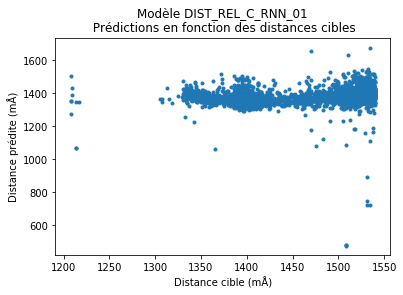

In [139]:
plot_sorted_targets_pred(targets, predictions)

![title](../figures/11.1-DIST_REL_C_01_preds_fonction_cibles.png)
